In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Esercitazione 8

La consegna chiedeva di stimare, tramite Monte Carlo variazionale (VMC), l'energia $E_0$ di ground state di una particella quantistica monodimensionale soggetta ad una Hamiltoniana ${\hat H}$ nota. 

Dato uno stato $T$ del sistema, $\Psi_T^{\sigma,\mu}(x)$ è la funzione d'onda ad esso associata. Il valore dell'energia $E_T$ (che sarà maggiore o uguale a quella dello stato fondamentale) può essere stimato campionando, mediante l'algoritmo di Metropolis, $x$ distribuita secondo $\rho^{\sigma, \mu} (x)=\frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}$ e valutando poi $g^{\sigma, \mu} (x)=\frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$. 

Tramite un'apposita scelta dei parametri $\mu$ e $\sigma$ è possibile minimizzare $E_T$ e dunque ottenere una stima di $E_0$.

## Esercizio 8.1

Per il primo esercizio ho fissato i valori dei due parametri da cui dipende la funzione d'onda semplicemente guardando la soluzione indipendente del problema fornita dal professore, qua riportata per avere un metro di confronto con cui valutare i risultati delle simulazioni. Nello specifico ho usato $\mu=0.85$ e $\sigma=0.65$.

Dopo una fase di equilibrazione, durante la quale mi sono anche assicurata che l'accettazione dell'algoritmo usato fosse all'incirca pari a $50\%$, ho fatto evolvere il sistema per $M=10^4$ passi divisi in $N=50$ blocchi misurando $\langle E_{T} \rangle$ e il suo errore. I risultati ottenuti, riportati in unità tc $\hbar=m=1$, risultano abbastanza in accordo con le previsioni teoriche. In particolare, all'ultimo blocco, $\langle E_{T} \rangle$ è compatibile con il valore di $E_0$ atteso entro $3\sigma$.

In [2]:
#codice scritto dal prof da usare come valore atteso

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

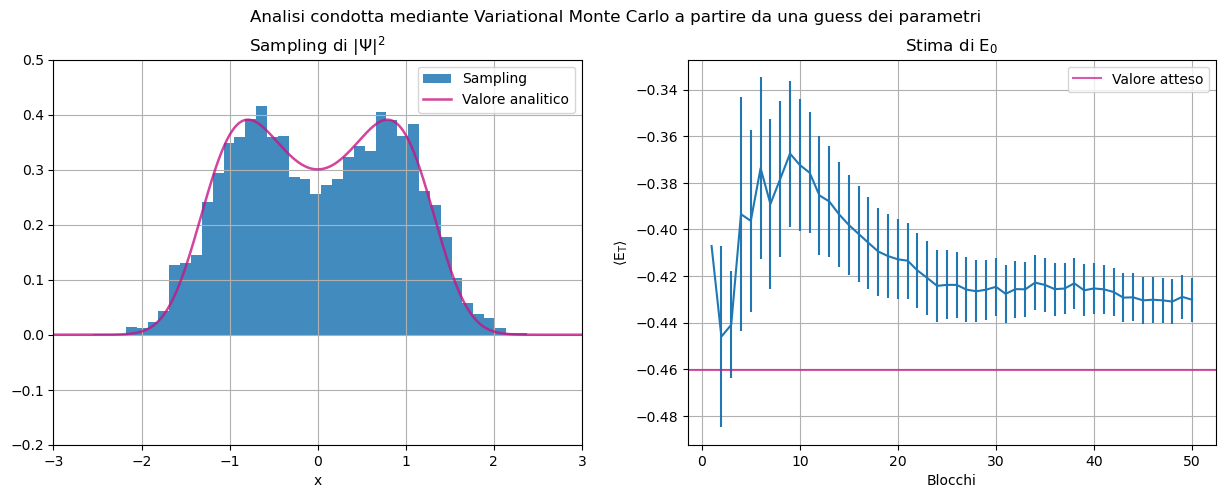

In [3]:
Nle=50  #numero di blocchi
lex=np.arange(Nle)+1  #vettore delle ascisse dei punti plottati

genx=np.loadtxt("genpoints.dat",  unpack="true")
ley, leerrors=np.loadtxt("locenergy.dat", usecols=(0, 1),  unpack="true")  #vettori delle ordinate dei punti plottati e delle barre d'errore

gpfig ,(gpplt1, gpplt2) = plt.subplots(1, 2, figsize=(15, 5))

gpplt1.hist(genx, 40, density=True, label="Sampling", alpha=0.85)
gpplt1.plot(x,(psi[0])**2, color="mediumvioletred", label="Valore analitico", linewidth=1.8, alpha=0.8)
gpplt1.set_title(r"Sampling di $|\Psi|^2$")
gpplt1.set_xlabel("x")
gpplt1.set_xlim((-3,3))
gpplt1.set_ylim((-0.2,0.5))
gpplt1.legend()
gpplt1.grid(True)

gpplt2.errorbar(lex, ley, yerr=leerrors)
gpplt2.axhline(y=-0.46046587969271535, color="mediumvioletred", label="Valore atteso", alpha=0.7)
gpplt2.set_xlabel("Blocchi")
gpplt2.set_ylabel(r"$\left<\mathrm{E_T}\right>$")
gpplt2.set_title(r"Stima di $\mathrm{E_0}$")
gpplt2.grid(True)
gpplt2.legend()

gpfig.suptitle("Analisi condotta mediante Variational Monte Carlo a partire da una guess dei parametri")
plt.show()

## Esercizio 8.2

Appoggiandomi al metodo sviluppato durante la prima parte dell'esercitazione, qui ho cercato, tramite il metodo di Simulated Annealing (SA), i valori $\sigma,\mu$ che minimizzano la funzione d'onda in esame e dunque tc $\langle E^{\sigma,\mu}_T \rangle \approx E_0$. 

Analizzando valori $\beta\in[0.5, 81]$, partendo dal minore e arrivando al maggiore con salti regolari, ho utilizzato un algoritmo di Metropolis che esplorasse lo spazio dei parametri considerati facendo uso delle energie calcolate tramite VMC. Per decidere quando incrementare il $\beta$ del passo corrente del Metropolis più esterno, valutavo la compatibilità fra due energie successive calcolate da quello interno (variazionale): quando entrambe erano compatibili entro $1\sigma$ l'una con l'altra, supponendo di non poter stimare con più precisione l'energia dello stato in esame, saltavo al valore di temperatura successivo. Ho inoltre monitorato il valore di accettazione in maniera tale da non farlo scendere troppo sotto il riferimento posto a $50\%$.

Di seguito, i grafici mostrano l'andamento dell'algoritmo di Simulated Annealing rispetto allo spazio dei parametri in esame e al variare delle energie valutate in funzione di $\beta$. Trovati i parametri corrispondenti all'energia minima, $\mu=0.823$ e $\sigma=0.634$, ho plottato il campionamento di $\rho^{\sigma, \mu} (x)$ realizzato e l'analisi a blocchi fatta sull'energia dello stato corrispondente. 

Qualitativamente il campionamento ottenuto risulta migliore rispetto al precedente ma, poichè i parametri considerati migliori dal SA non si discostano molto dalla scelta effettuata prima, l'accuratezza della stima di $E_0$ non è aumentata visibilmente. Il valore all'ultimo blocco è comunque considerato in linea con quanto atteso essendo compatibile con il valore analitico entro $3\sigma$.

In [4]:
#carico tutti i dati

#valori di beta analizzati e numero di step per ognuno dei essi
betas, ns=np.loadtxt("beta.dat", usecols=(0, 1),  unpack="true")  
#valori di <H> a fisso beta e delle barre d'errore
hs, herrs=np.loadtxt("hstep.dat", usecols=(0, 1),  unpack="true")  
#valori di sigma e mu finali per ogni beta
ts, mus, sigmas=np.loadtxt("params.dat", usecols=(0, 1, 2),  unpack="true")
#sample di |psi|^2 finale
finx=np.loadtxt("finalpoints.dat",  unpack="true")  
#analisi a blocchi di <H> con parametri ottimali
finh, finherrs=np.loadtxt("finalenergies.dat", usecols=(0, 1),  unpack="true")  

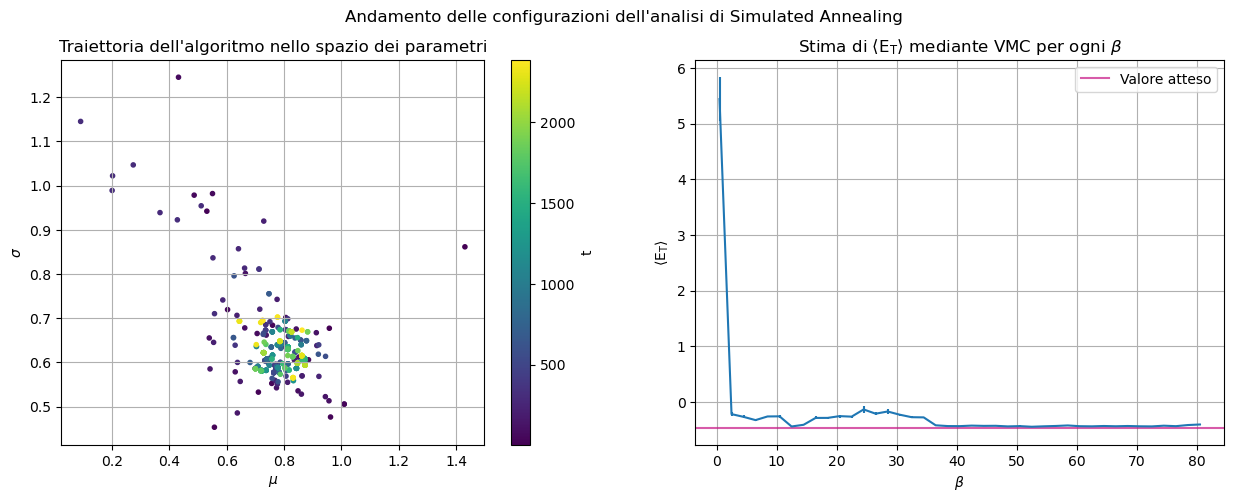

In [5]:
cfig ,(cplt1, cplt2) = plt.subplots(1, 2, figsize=(15, 5))

#guardo l'andamento dell'algoritmo in funzione del tempo praticamente
sc = cplt1.scatter(mus, sigmas, c=ts, cmap="viridis", marker='.')  
cbar = cfig.colorbar(sc, ax=cplt1)  
cbar.set_label("t")
cplt1.set_xlabel(r"$\mu$")
cplt1.set_ylabel(r"$\sigma$")
cplt1.set_title("Traiettoria dell'algoritmo nello spazio dei parametri")
cplt1.grid(True)

cplt2.errorbar(betas, hs, yerr=herrs)
cplt2.axhline(y=-0.46046587969271535, color="mediumvioletred", label="Valore atteso", alpha=0.7)
cplt2.set_xlabel(r"$\beta$")
cplt2.set_ylabel(r"$\left<\mathrm{E_T}\right>$")
cplt2.set_title(r"Stima di $\left<\mathrm{E_T}\right>$ mediante VMC per ogni $\beta$")
cplt2.grid(True)
cplt2.legend()

cfig.suptitle("Andamento delle configurazioni dell'analisi di Simulated Annealing")
plt.show()

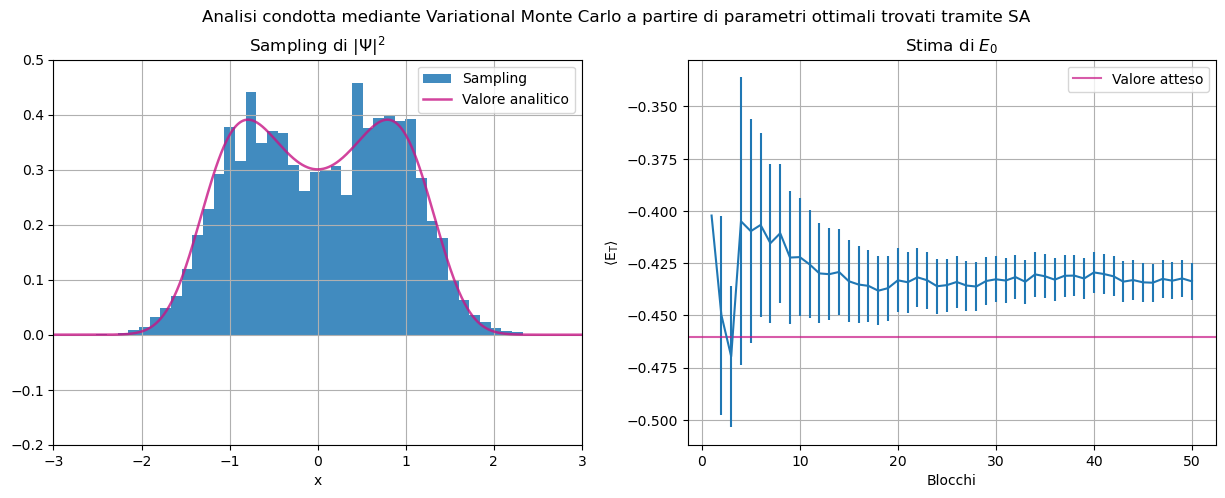

In [7]:
opfig ,(opplt1, opplt2) = plt.subplots(1, 2, figsize=(15, 5))

opplt1.hist(finx, 40, density=True, label="Sampling", alpha=0.85)
opplt1.plot(x,(psi[0])**2, color="mediumvioletred", label="Valore analitico", linewidth=1.8, alpha=0.8)
opplt1.set_title(r"Sampling di $|\Psi|^2$")
opplt1.set_xlabel("x")
opplt1.set_xlim((-3,3))
opplt1.set_ylim((-0.2,0.5))
opplt1.legend()
opplt1.grid(True)

opplt2.errorbar(lex, finh, yerr=finherrs)
opplt2.axhline(y=-0.46046587969271535, color="mediumvioletred", label="Valore atteso", alpha=0.7)
opplt2.set_xlabel("Blocchi")
opplt2.set_ylabel(r"$\left<\mathrm{E_{T}}\right>$")
opplt2.set_title(r"Stima di $E_0$")
opplt2.grid(True)
opplt2.legend()

opfig.suptitle("Analisi condotta mediante Variational Monte Carlo a partire di parametri ottimali trovati tramite SA")
plt.show()

Mi accontento di compatibilità a tre sigma altrimenti impazzisco :)